In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
import matplotlib.pyplot as plt


In [2]:
# Parameters
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50
DATASET_PATH = "PlantVillage"


In [3]:
# Load Dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
# Splitting dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [6]:
# Performance improvements
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [7]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
# Define a function to create and compile the model
def create_and_compile_model(base_model, num_classes=len(class_names)):
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    return model


In [9]:
import ssl
import certifi

ssl._create_default_https_context = ssl._create_unverified_context

# Training and evaluating ResNet50 model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
resnet_model = create_and_compile_model(resnet_base)
print("Training ResNet50 model...")
resnet_history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)

Training ResNet50 model...
Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 485s 9s/step - accuracy: 0.8223 - loss: 0.6373 - val_accuracy: 0.4740 - val_loss: 70.4706
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 343s 6s/step - accuracy: 0.9596 - loss: 0.1207 - val_accuracy: 0.4740 - val_loss: 4289.3989
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 360s 7s/step - accuracy: 0.9783 - loss: 0.0629 - val_accuracy: 0.5469 - val_loss: 3.1805
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 323s 6s/step - accuracy: 0.9835 - loss: 0.0477 - val_accuracy: 0.9375 - val_loss: 0.1369
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 322s 6s/step - accuracy: 0.9911 - loss: 0.0247 - val_accuracy: 0.9844 - val_loss: 0.0841
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2819s 53s/step - accuracy: 0.9847 - loss: 0.0588 - val_accuracy: 0.4792 - val_loss: 181.7730
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 810s 15s/step - accuracy: 0.9835 - loss: 0.0647 - val_accuracy: 0.5104 - val_loss: 62.7928
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 671s 13s/step - accuracy: 0.9803 - l

In [10]:
print("Evaluating ResNet50 model...")
resnet_scores = resnet_model.evaluate(test_ds)
print(f"ResNet50 Test Loss: {resnet_scores[0]}, Test Accuracy: {resnet_scores[1]}")


Evaluating ResNet50 model...
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 995ms/step - accuracy: 0.9986 - loss: 0.0038
ResNet50 Test Loss: 0.008070605807006359, Test Accuracy: 0.99609375


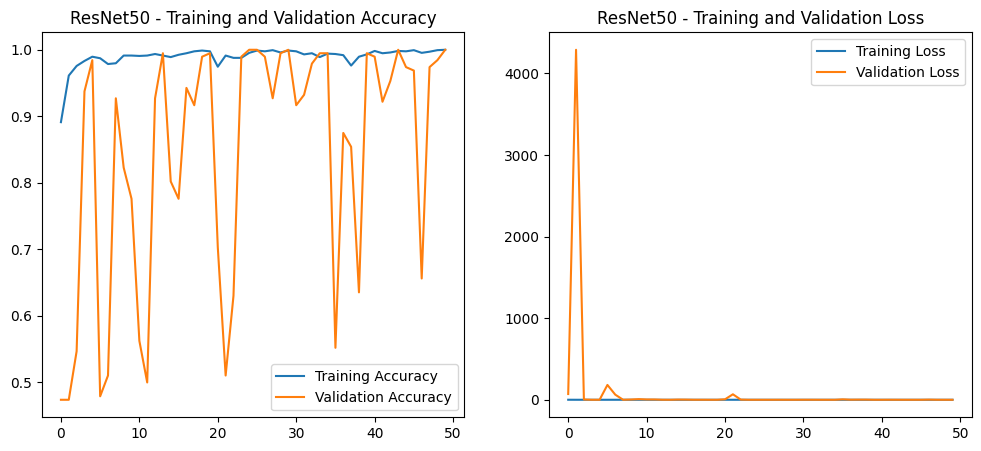

In [11]:
# Plotting ResNet50 results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), resnet_history.history['accuracy'], label='Training Accuracy')
plt.plot(range(EPOCHS), resnet_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('ResNet50 - Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), resnet_history.history['loss'], label='Training Loss')
plt.plot(range(EPOCHS), resnet_history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('ResNet50 - Training and Validation Loss')

plt.show()
